# Modelos ART utilizando a função VAT

## Importando bibliotecas

In [23]:
%pip install artlib
%pip install pyclustertend

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision.datasets import USPS
from artlib import FuzzyART, FuzzyARTMAP, FusionART
from sklearn.metrics import classification_report, adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.utils import resample
from pyclustertend import vat
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [12]:
from metricas import *

## Aplicando VAT

O VAT exige um X de 2 dimensões e isso conflita com o modelo ART.

Por isso, decidi separar essa parte do código.

X: (7291, 16, 16)  y: (7291,)


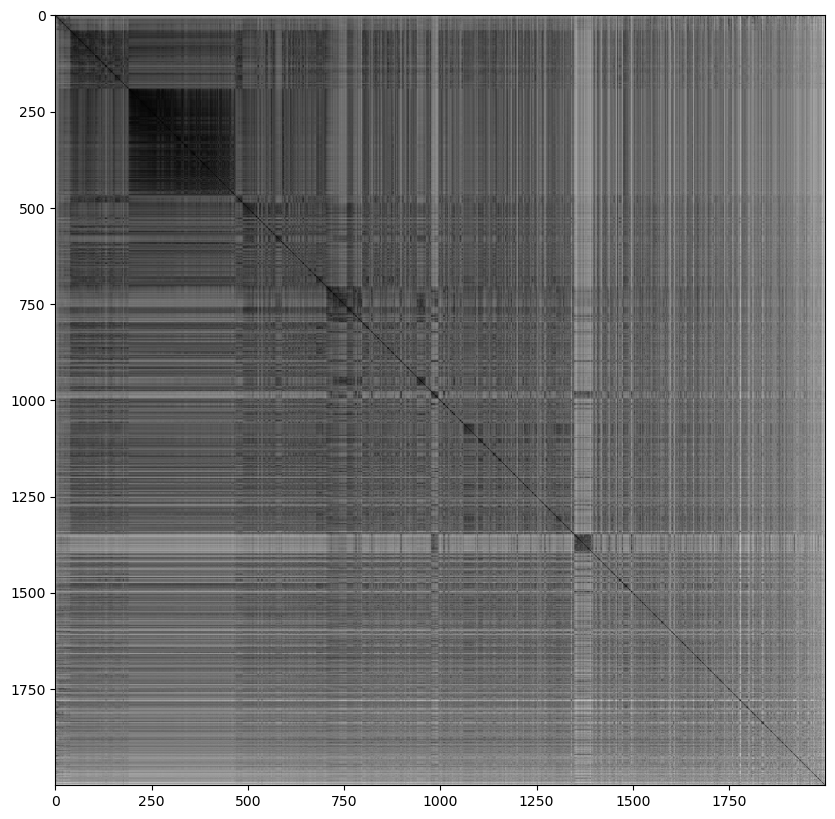

In [ ]:
transform = transforms.ToTensor()
full_dataset = datasets.USPS(root='./data', train=True, download=True, transform=transform)

X_list = []
y_list = []

for img, label in full_dataset:
    X_list.append(img.numpy().squeeze())  # shape (16,16)
    y_list.append(label)

X = np.array(X_list)  # (7291, 16, 16)
y = np.array(y_list)  # (7291,)
print("X:", X.shape, " y:", y.shape)

# Achatando os dados
# Isso é necessário para o scaler
nsamples, h, w = X.shape
X_flat = X.reshape((nsamples, h * w))  # (7291, 256)

scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

X_sample = resample(X_flat_scaled, n_samples=2000, random_state=42)

vat(X_sample)


De acordo com a documentação da biblioteca, a forma de interpretar a imagem é contando o número de quadrados pretos na diagonal principal. Esse valor pode representar o número de clusters.

## Baixando e ordenando dados

In [26]:
# Aprendizado não supervisionado
train_data = USPS(root='./USPS/', train=True, download=True)
test_data = USPS(root='./USPS/', train=False, download=True)

X_train = train_data.data
y_train = torch.tensor(train_data.targets, dtype=torch.long)

X_test = test_data.data
y_test = torch.tensor(test_data.targets, dtype=torch.long)

print(X_train.shape)

# as imagens do conjunto são 16x16
n_dim = 16 * 16

#flatten images
X_train = X_train.reshape(-1, n_dim)
X_test = X_test.reshape(-1, n_dim)

print(X_train.shape)

# Ordenando dados
sorted_indices_train = torch.argsort(y_train)
X_train_sorted = X_train[sorted_indices_train]
y_train_sorted = y_train[sorted_indices_train]

sorted_indices_test = torch.argsort(y_test)
X_test_sorted = X_test[sorted_indices_test]
y_test_sorted = y_test[sorted_indices_test]

100%|██████████| 6.58M/6.58M [00:15<00:00, 417kB/s] 
100%|██████████| 1.83M/1.83M [00:06<00:00, 262kB/s] 


(7291, 16, 16)
(7291, 256)


## Fuzzy ART

Aprendizado não supervionado


In [27]:
fuzzy_art_model = FuzzyART(rho=0.3, alpha=0.0, beta=1.0)

# Estabelecendo bounds
lower_bounds = np.zeros(n_dim)
upper_bounds = np.full(n_dim, 255.0)

fuzzy_art_model.set_data_bounds(lower_bounds, upper_bounds)

# Normalização e complement coding
train_X_fuzzy_art = fuzzy_art_model.prepare_data(X_train)
test_X_fuzzy_art  = fuzzy_art_model.prepare_data(X_test)

In [28]:
fuzzy_art_model.fit(train_X_fuzzy_art)
fuzzy_art_predictions = fuzzy_art_model.predict(test_X_fuzzy_art)

In [ ]:
ARI = adjusted_rand_score(y_test,fuzzy_art_predictions)
print(f'O ARI do modelo FuzzyART foi: {ARI}')
num_clusters = fuzzy_art_model.n_clusters
print(f"O número de clusters foi: {num_clusters}")

O ARI do modelo FuzzyART foi:0.04754222620721928
O número de clusters foi:284


## Fuzzy ARTMAP

In [30]:
fuzzy_artmap_model = FuzzyARTMAP(rho=0.3, alpha=0.0, beta=1.0)

# Os limites foram definidos na parte do Fuzzy ART
fuzzy_artmap_model.module_a.set_data_bounds(lower_bounds, upper_bounds)

# Normalização e complement coding
train_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_train)
test_X_fuzzy_artmap = fuzzy_artmap_model.prepare_data(X_test)

In [31]:
fuzzy_artmap_model.fit(train_X_fuzzy_artmap, y_train)
fuzzy_artmap_predictions = fuzzy_artmap_model.predict(test_X_fuzzy_artmap)


Classification report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       359
           1       0.99      0.89      0.94       264
           2       0.89      0.88      0.89       198
           3       0.89      0.75      0.81       166
           4       0.83      0.82      0.83       200
           5       0.82      0.75      0.78       160
           6       0.89      0.91      0.90       170
           7       0.43      0.93      0.58       147
           8       0.78      0.72      0.75       166
           9       0.74      0.36      0.49       177

    accuracy                           0.81      2007
   macro avg       0.82      0.79      0.79      2007
weighted avg       0.85      0.81      0.82      2007



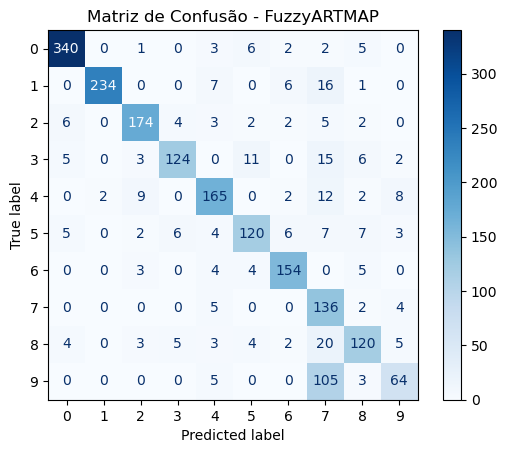

In [32]:
report = classification_report(y_test, fuzzy_artmap_predictions)
matrix = confusion_matrix(y_test, fuzzy_artmap_predictions)

print("\nClassification report:")
print(report)

cm = confusion_matrix(y_test, fuzzy_artmap_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - FuzzyARTMAP")
plt.show()